### Part5: Coincidence detection with AMPA-like and NMDA-like synapses

Coincidence detection can be emulated on Dynap-SE1 by combining the AMPA-like (DPI fast) and the NMDA-like (DPI slow) synapse.

Let's start with importing Brian2:

In [2]:
from brian2 import *
from DynapSE import DynapSE
from parameters import constants

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from parameters.set_params import set_params

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90 
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

### Input Spike Train

Let's generate a Spike Train with N=num_spikes spikes*2, which consists of two spike trains:
- input pulses via the **AMPA** synapse: regular spike train with rate=2Hz 
- input pulses via the **NMDA** synapse: generated from the first spike train, by regularly shifting the i-th spike with respect to the i-th AMPA spike by 10ms*i.

Run the next cell to visualize the resulting input spike train:

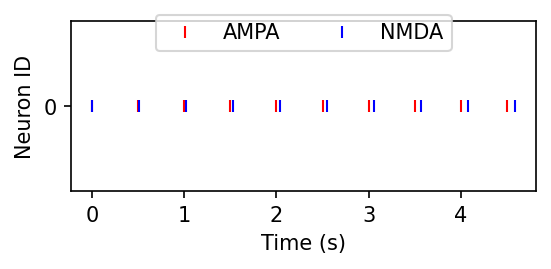

In [3]:
num_spikes = 10
rate = 2            # Hz
inp_duration = num_spikes/rate # second
spikes = np.zeros(int(inp_duration*1000))
dt = int(1000/rate)
end = int(inp_duration*1000)
spikes[0:end:dt] = 1.0

spike_timing_ampa = np.where(spikes==1)[0] * ms # Timing of spikes
spike_timing_nmda = np.array([spike_timing_ampa[idx]/ms+idx*10 for idx in range(len(spike_timing_ampa))])*ms

neuron_indices_nmda = np.zeros(len(spike_timing_nmda)) # ID of spike sources
neuron_indices_ampa = np.zeros(len(spike_timing_ampa)) # ID of spike sources

# Spike Generator
input_spike_generator_ampa = SpikeGeneratorGroup(1, indices=neuron_indices_ampa, times=spike_timing_ampa, name='InpAMPA')  
input_spike_generator_nmda = SpikeGeneratorGroup(1, indices=neuron_indices_nmda, times=spike_timing_nmda, name='InpNMDA')  

# Plot
plt.figure(figsize=(4,1.5),dpi=150)
plt.plot(spike_timing_ampa, neuron_indices_ampa, 'r|', label='AMPA')
plt.plot(spike_timing_nmda, neuron_indices_nmda, 'b|', label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.xlabel("Time (s)")
plt.ylabel("Neuron ID")
plt.ylim(-0.25, .25)
plt.yticks([0])
plt.show()

### Brian2 Network

In [4]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

# DPI neuron
DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1

# DPI synapses
DPI_AMPA_synapse = chip.add_connection(input_spike_generator_ampa, DPI_neuron, synapse_type='AMPA') # Define a slow excitatory synapse
DPI_NMDA_synapse = chip.add_connection(input_spike_generator_nmda, DPI_neuron, synapse_type='NMDA')
chip.connect(DPI_NMDA_synapse, True)
chip.connect(DPI_AMPA_synapse, True)

1 neurons are allocated from Core_1.


### Parameters

### 1. Time constants:
In order to mimic the biological non-linear summation of the NMDA voltage-gating channels, we will set the neuron and synaptic leakage such that:
$$ \tau_{AMPA} <\tau < \tau_{NMDA}$$

In [5]:
# Leakage parameter:
dynapse_param['Itau'] = 5 *pA
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA

# Equivalent time constants:
kappa = (constants.kappa_n + constants.kappa_n) / 2
tau_ampa = dynapse_param['C_syn_ampa'] * constants.Ut /(constants.kappa_p * dynapse_param["I_tau_syn_ampa"])
tau_nmda = dynapse_param['C_syn_nmda'] * constants.Ut /(constants.kappa_p * dynapse_param["I_tau_syn_nmda"])
tau = (dynapse_param['Cmem'] * constants.Ut) / (kappa * dynapse_param['Itau'])

print('Leak AMPA {} A - Tau AMPA: {} ms'.format(dynapse_param["I_tau_syn_ampa"], tau_ampa*1e3))
print('Leak NMDA {} A - Tau NMDA: {} ms'.format(dynapse_param["I_tau_syn_nmda"], tau_nmda*1e3))
print('Leak neuron {} A - Tau neuron: {} ms'.format(dynapse_param["Itau"], tau*1e3))

Leak AMPA 1e-11 A - Tau AMPA: 5.681818181818182 ms
Leak NMDA 1e-12 A - Tau NMDA: 56.81818181818182 ms
Leak neuron 5e-12 A - Tau neuron: 10.000000000000002 ms


#### 2. Neuron DPI Gain: 
When the approximation to a first order differential equation holds (see part1 for more details), the steady state value of the DPI is $$I_{mem, ss}=\frac{I_g I_{in}}{I_{tau}}$$.

If we set the $I_g = I_{tau}$, the only parameter left that controls the gain of the $Imem$ is the $I_{in}$. Therefore, we chose:

In [6]:
dynapse_param['Ith'] = dynapse_param['Itau']

#### 3. Synapse DPI gain:

Similarly, for the synapse, if $I_{syn} \gg Io$):
    $$I_{syn, ss}=\frac{I_g I_{w} w}{I_{tau}}$$
else:
    $$ I_{syn_0} = \frac{I_{w}I_{g} w}{ I_{tau}  ( \frac{I_g}{I_{syn,nmda}} + 1 ) } \approx \frac{I_{w}I_{g} w}{ I_{tau}  ( \frac{I_g}{Io} + 1 ) } $$

with $w$ set to 1 by default when the synapse object is created. 

Again, if we fix the ratio $I_g/I_{tau}$, the only parameter left that controls the synaptic strength is the $I_w$

In [7]:
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"]

Let's start with some initial weight values:

In [8]:
dynapse_param['I_wo_syn_nmda'] = 2.5 * nA 
dynapse_param['I_wo_syn_ampa'] = 20 * nA

Which, if when $I_{syn} \approx I_o$, leads to the following EPSC amplitude:

In [8]:
EPSC_nmda = dynapse_param['I_wo_syn_nmda']*dynapse_param['I_g_syn_nmda']/(dynapse_param["I_tau_syn_nmda"]*((dynapse_param["I_g_syn_nmda"]/constants.Io)+1))
print('EPSC NMDA Amplitude @t=0:', EPSC_nmda)

EPSC_ampa = dynapse_param['I_wo_syn_ampa']*dynapse_param['I_g_syn_ampa']/(dynapse_param["I_tau_syn_ampa"]*((dynapse_param["I_g_syn_ampa"]/constants.Io)+1))
print('EPSC AMPA Amplitude  @t=0:', EPSC_ampa)

EPSC NMDA Amplitude @t=0: 0.83333333 nA
EPSC AMPA Amplitude  @t=0: 0.95238095 nA


Finally, let's initialize the Vnmda threshold to an arbitrary value. 

In [9]:
dynapse_param["Vnmda"] = 158*mV

Now we are ready to apply our parameters to the neuron and synapse objects:

In [11]:
for core in chip.cores:
    set_params(core.neurons, dynapse_param)

Now we will connect our spike generator groups to one target neuron, via one AMPA-like and one NMDA-like DPI circuit. 

### Run simulation

In [9]:
# Monitors
mon_neuron_input_ampa  = SpikeMonitor(input_spike_generator_ampa, name='mon_neuron_input_ampa')
mon_neuron_input_nmda  = SpikeMonitor(input_spike_generator_nmda, name='mon_neuron_input_nmda')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda', record=[0])
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'I_syn_ampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Imem', record=True)
mon_neuron_vmem  = StateMonitor(DPI_neuron, 'Vmem', record=True)
mon_neuron_I_syn_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda_dp_clip', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator_ampa, input_spike_generator_nmda, DPI_neuron, DPI_NMDA_synapse, 
             DPI_AMPA_synapse, mon_neuron_input_ampa, mon_neuron_input_nmda, mon_synapse_nmda, 
             mon_synapse_ampa, mon_neuron_output, mon_neuron_state, mon_neuron_vmem, mon_neuron_I_syn_nmda])


In [12]:
# Simulation
duration = 2 * 1000 * ms

# Run
# store network state before run
network.store()
network.run(duration)

### Plot

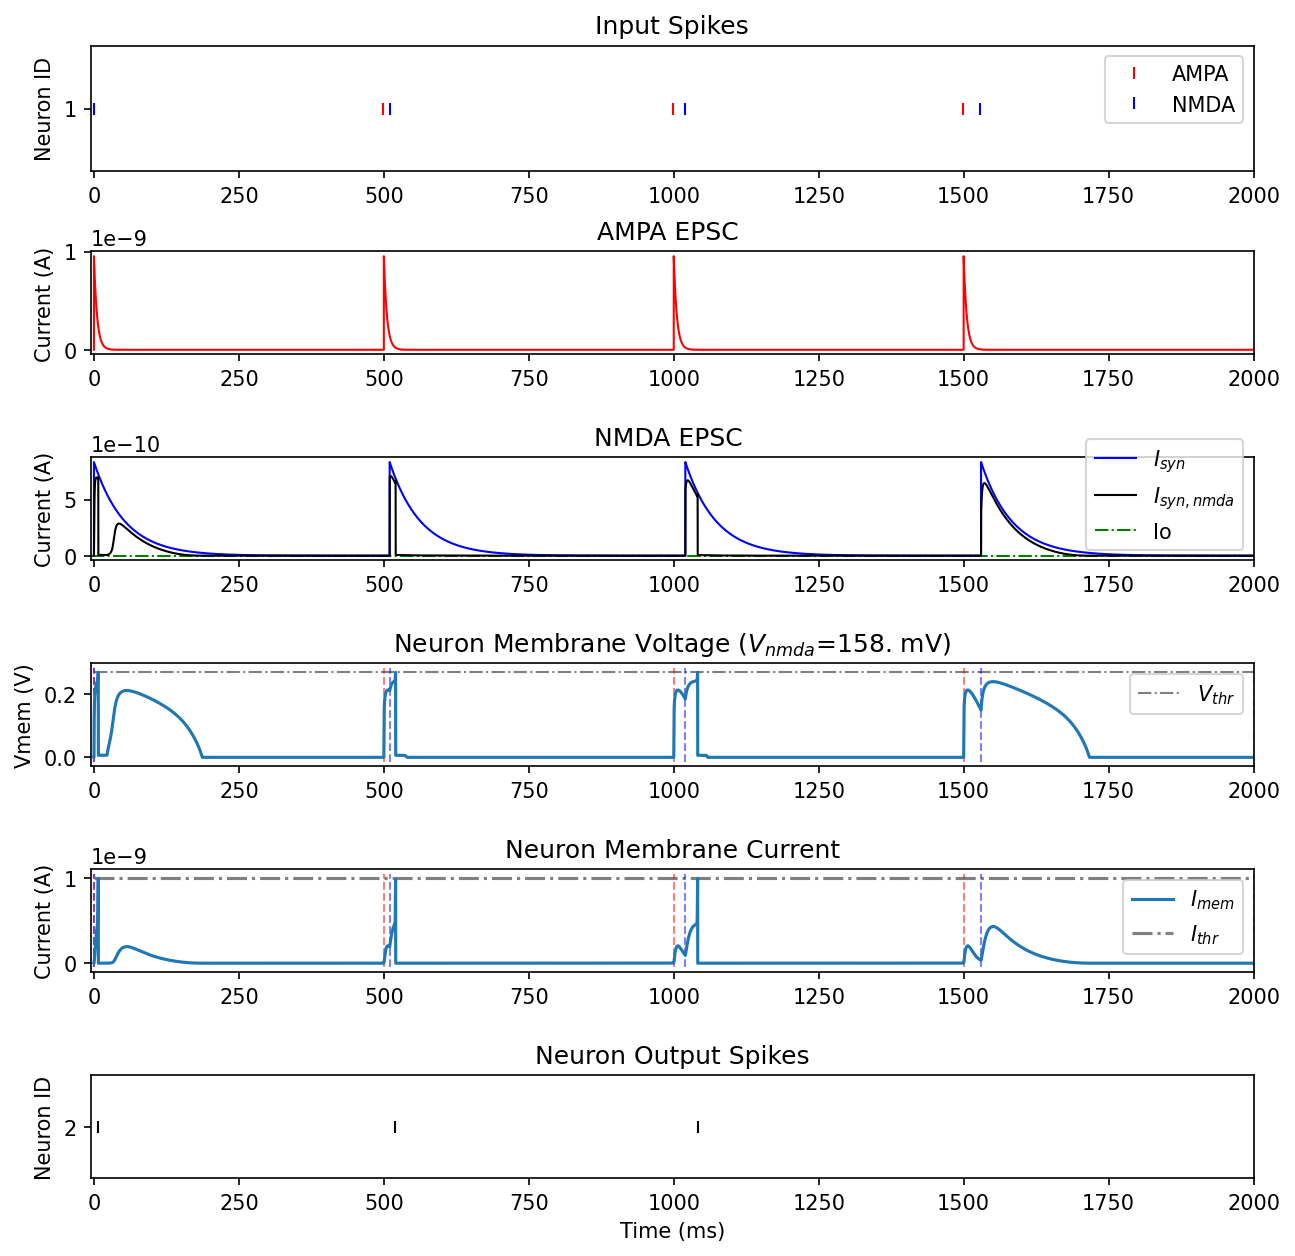

In [14]:
f = plt.figure(figsize=(10,10),dpi=150)
plt.subplots_adjust(hspace=1, wspace=.8)
tstart = 0
tend   = int(duration*1000) # ms
Vthr = constants.Ut/DPI_neuron.kappa*log(dynapse_param['Ispkthr']/constants.Io)

# Input Spikes 
plt.subplot(511)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_ampa.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'r|', label='AMPA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_nmda.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'b|', label='NMDA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.legend()
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
plt.xlim(-5, duration/ms)
#plt.xlabel('Time (ms)')

plt.subplot(612)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1, c='r')
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('AMPA EPSC ')

plt.subplot(613)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.I_syn_nmda[0][tstart*s:tend*s], linewidth=1, label='$I_{syn}$', c='b')
plt.plot(mon_neuron_I_syn_nmda.t[tstart*s:tend*s]/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0][tstart*s:tend*s], linewidth=1, c='k', label='$I_{syn,nmda}$')
plt.hlines(y=constants.Io, xmin=-5, xmax=duration/ms, color='green', linestyles='-.', label='Io', linewidth=1)
plt.legend()
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('NMDA EPSC ')

plt.subplot(614)
plt.hlines(y=Vthr, xmin=0, xmax=duration/ms, color='grey', linestyles='-.', linewidth=1, label='$V_{thr}$')
plt.legend()
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_vmem.Vmem[0][tstart*s:tend*s], linewidth=1.5)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.title('Neuron Membrane Voltage ($V_{nmda}$='+str(dynapse_param["Vnmda"])+')')
plt.ylabel('Vmem (V)')
plt.xlim(-5, duration/ms)

plt.subplot(615)
imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, imem)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='grey', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlim(-5, duration/ms)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)


plt.subplot(616)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.xlim(-5, duration/ms)
plt.show()

f.savefig('./fig/part5_DPI_coincidenceDetection_'+str(np.array(DPI_NMDA_synapse.Vnmda)[0])+'.pdf')

Let's now sweep across different $V_{nmda}$ values and observe how the number of output spikes changes as a function of $V_{nmda}$

# Sweep Vnmda

Vnmda:  110
Vnmda:  126
Vnmda:  142
Vnmda:  158
Vnmda:  174
Vnmda:  190


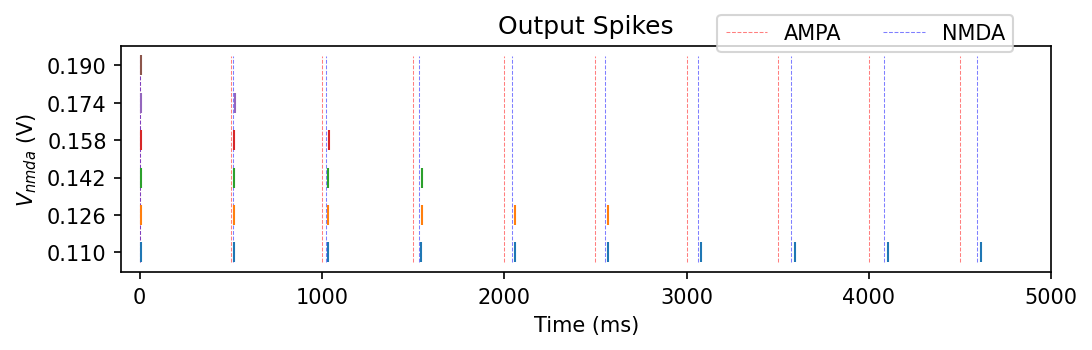

In [15]:
output_spikes = {}

network.restore()
dict_vmem = {}
dict_imem = {}
dict_inmda = {}
dict_out_spikes = {}

# Sweep V_nmda threshold values:
sampled_nmda = np.linspace(110, 190, 6).astype(int) #150

for vnmda in sampled_nmda:
    print('Vnmda: ', vnmda)
    dynapse_param['Vnmda'] = vnmda*mV
        
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)
        
    # Simulation
    duration = inp_duration * 1000 * ms

    # Run
    network.run(duration)
    
    dict_inmda[vnmda] = (mon_neuron_I_syn_nmda.t/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0])
    dict_imem[vnmda] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    dict_vmem[vnmda] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])
    dict_out_spikes[vnmda] = mon_neuron_output.t/ms
    # (The next one does not depend on Vnmda)
    iampa = (mon_synapse_ampa.t/ms, mon_synapse_ampa.I_syn_ampa[0])
    
    network.restore()
    
# Plot output spikes:
f = plt.figure(figsize=(8,2),dpi=150)
plt.subplot(111)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
plt.title('Output Spikes')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.8, 1.18))

In [16]:
# For each pair of input ISI, label the pair of input spike with True if an output spike was generated. 
mask_out_spike = {}
for nmda in sampled_nmda:
    
    mask_out_spike[nmda] = np.zeros(len(spike_timing_ampa))
    # Loop over the spike times of the AMPA synapse
    for ii, t_ampa in enumerate(spike_timing_ampa/ms):
        # If any output spike is recorded during that time window:
        if len(np.where( np.logical_and( dict_out_spikes[nmda]>=t_ampa, dict_out_spikes[nmda]<(t_ampa+1/rate*1e3) ) )[0])>0:
            mask_out_spike[nmda][ii]=1
            
# This mask will be used in the following section

### Compare to DP characteristic

Let's now analyse the output spikes by looking at the DP characteristics. For that we will ignore, for now, the first pair of
AMPA,NMDA input spikes at time t=0 and focus our attention on the next 4 pair of spikes. 

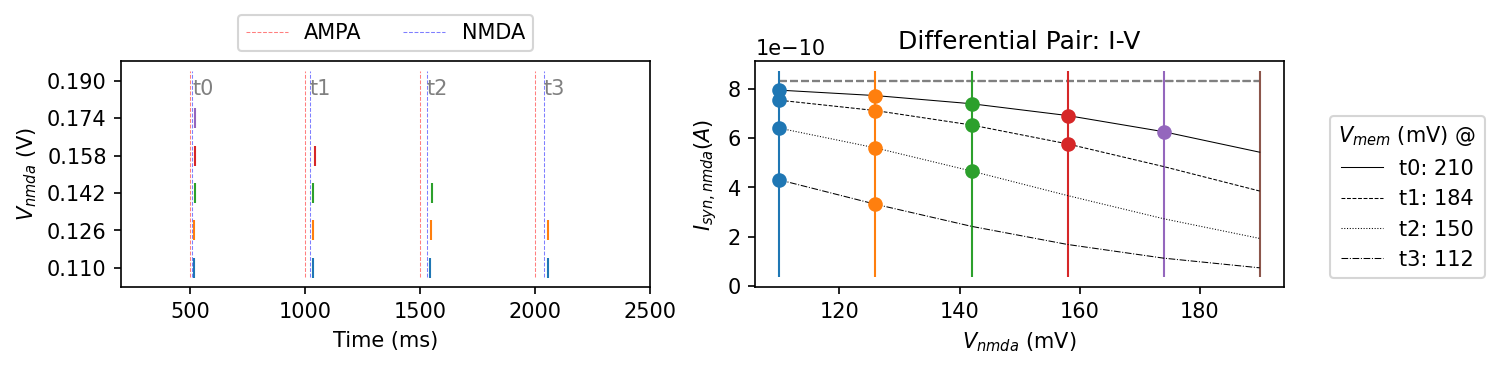

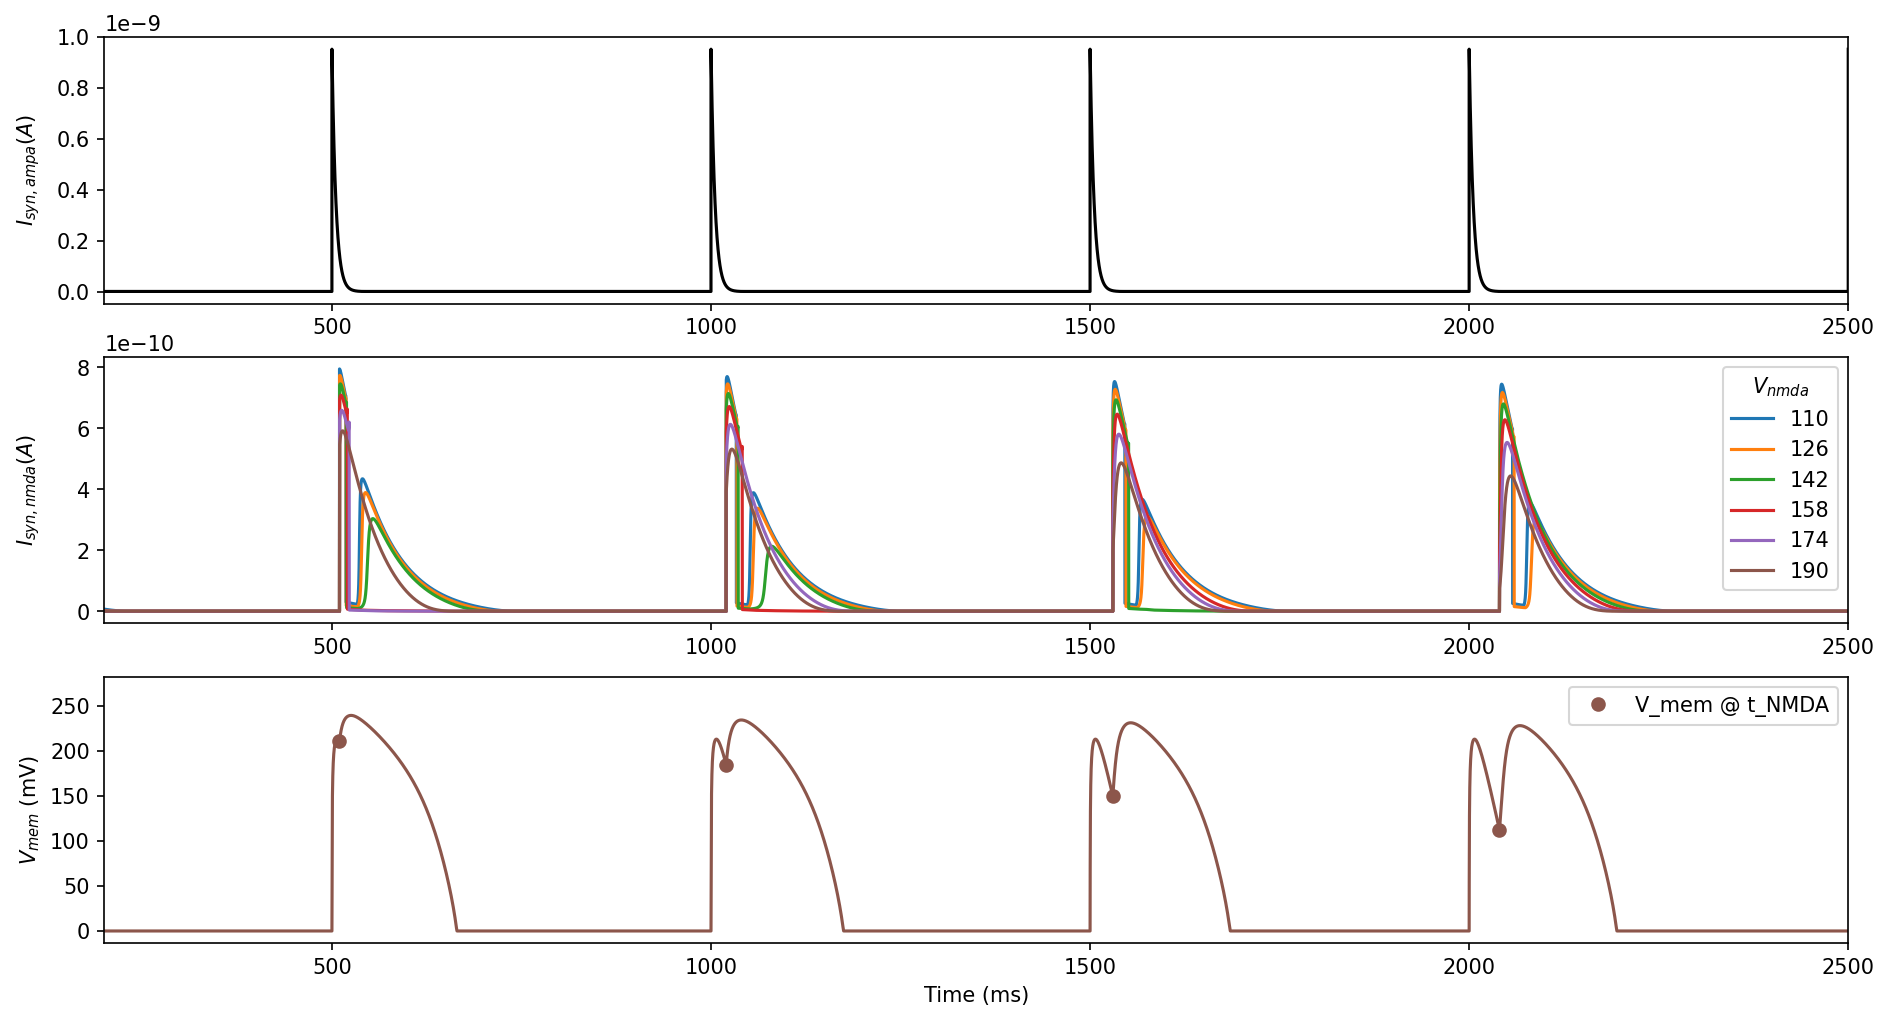

In [20]:
# Plot output spikes:
f = plt.figure(figsize=(10,2),dpi=150)

# Rasterplot
plt.subplot(121)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(.5, 1.25))
plt.xlim(200,2500)

input_isi = spike_timing_nmda[1:5]-spike_timing_ampa[1:5]
for ii, isi in enumerate(input_isi):
    plt.text(spike_timing_nmda[1+ii]/ms, ylim[-1]-.01, 't'+str(ii), c='grey')
    
# DPI Characteristics
I_syn = EPSC_nmda
plt.subplot(122)
style = ['solid', 'dashed', 'dotted', 'dashdot']

# Range Vmem
t_vmem = dict_vmem[110][0]
vmem = dict_vmem[110][1]
idx_vmem_at_nmda = [np.where(t_vmem<=t_nmda)[0][-1] for t_nmda in spike_timing_nmda/ms]
vmem_at_nmda = vmem[idx_vmem_at_nmda]/mV

# I-Vnmda curves for a range of vmem values
for v, vmem in enumerate(vmem_at_nmda[1:5]):
    vmem = vmem*mV
    i_syn_nmda = I_syn/(1 + np.exp(constants.kappa_n*(sampled_nmda*mV-vmem)/constants.Ut))
    p = plt.plot(sampled_nmda, i_syn_nmda/nA*1e-9, linestyle=style[v],c='k', linewidth=.5, label='t'+str(v)+': '+str(int(vmem/mV)))
    plt.hlines(y=I_syn/nA*1e-9, xmin=sampled_nmda[0], xmax=sampled_nmda[-1], linestyle='--', color='grey', linewidth=1)

ylim = plt.ylim()
for i, vnmda in enumerate(sampled_nmda):
    plt.vlines(vnmda, ylim[0], ylim[1], linestyle='-', color=colors[i], linewidth=1)

plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.4, 0.4), title='$V_{mem}$ (mV) @')
plt.xlabel('$V_{nmda}$ (mV)')
plt.ylabel('$I_{syn,nmda} (A)$')
plt.title('Differential Pair: I-V')

# Label intersection between DP characteristic and Vnmda if an output spike was generated:
for vv, vmem in enumerate(vmem_at_nmda[1:5]):
    for nn, vnmda in enumerate(sampled_nmda):
        if mask_out_spike[vnmda][vv+1]==1: # +1 because we are skipping the first input pair of spikes
            i_syn_nmda = I_syn/(1 + np.exp(constants.kappa_n*(vnmda-vmem)*mV/constants.Ut))
            plt.plot(vnmda, i_syn_nmda, 'o', c=colors[nn])
            
# Plot Vmem, EPSC AMPA, and EPSC NMDA as a function of Vnmda
f = plt.figure(figsize=(15,8),dpi=150)
plt.subplot(3,1,1)
plt.plot(iampa[0], iampa[1], c='k')
plt.xlim(200,2500)
plt.ylabel('$I_{syn,ampa} (A) $')
plt.subplot(3,1,2)
for vnmda in sampled_nmda:
    plt.plot(dict_inmda[vnmda][0], dict_inmda[vnmda][1], label=str(vnmda))
plt.legend(title='$V_{nmda}$')
plt.xlim(200,2500)

plt.ylabel('$I_{syn,nmda} (A) $')
plt.subplot(3,1,3)
plt.plot(dict_vmem[sampled_nmda[-1]][0], dict_vmem[sampled_nmda[-1]][1]/mV, c=colors[len(sampled_nmda)-1])
plt.plot(spike_timing_nmda/ms,vmem_at_nmda, 'o', c=colors[len(sampled_nmda)-1], label='V_mem @ t_NMDA')
plt.legend()
plt.ylabel('$V_{mem}$ (mV)')
plt.xlim(200,2500)
plt.xlabel('Time (ms)')

f.align_ylabels()

As shown in the I-V characteristic of the DP, the $V_{nmda}$ regulates the amount of $I_{nmda}$ that flows through the neuron $C_{mem}$ (and eventually makes the neuron fire) depending on the value of $V_{mem}$ at the time of the NMDA input spike: The higher $V_{mem}$ at the time of the NMDA spike, i.e. the shorter the input AMPA-NMDA ISI, the larger the fraction of injected $I_{nmda}$.

However, in this parameter configuration, the neuron sensitivity to the input ISI is regulated mostly by the AMPA EPSC (amplitude and tau) since the amplitude of the AMPA EPSC is one order of magnitude higher than the NMDA amplitude. 

$$I_{syn} = I_{AMPA} + I_{NMDA} \approx I_{AMPA}$$

The effect of the AMPA spike is to bring the $V_{mem}$ right below the $V_{thr}$. When the NMDA input current comes in, even a little amount is enough to bring the $V_{mem}$ closer to the spiking threshold and to make the neuron fire. In other words, as the AMPA EPSC is larger than the NMDA EPSC, the effect of the AMPA exponential decay as a function of time (which determines the value of $V_{mem}$ at the time of the NMDA spike) dominates over the $I_{nmda}$ modulation via the $V_{nmda}$ threshold and, therefore, becomes the main factor controlling the neuron sensitivity to the input ISI.

## Let's play with different ampa and nmda synaptic weights

Parameters:
1. $I_{w,nmda}$
2. $I_{w,ampa}$
3. $I_{\tau}, I_{\tau, ampa}, I_{\tau,nmda}$
4. $V_{nmda}$

### 1. $I_{w,nmda}$

**Goal**: to use the DP of the DPI slow synapse as a digital gate, i.e. with a steep DP I-V sigmoid characteristic.

What is the relationship between the linear range of the sigmoid DP characteristic and the input weight bias?

Text(0.5, 0, '$I_{w,nmda}$ (nA) (gain=1)')

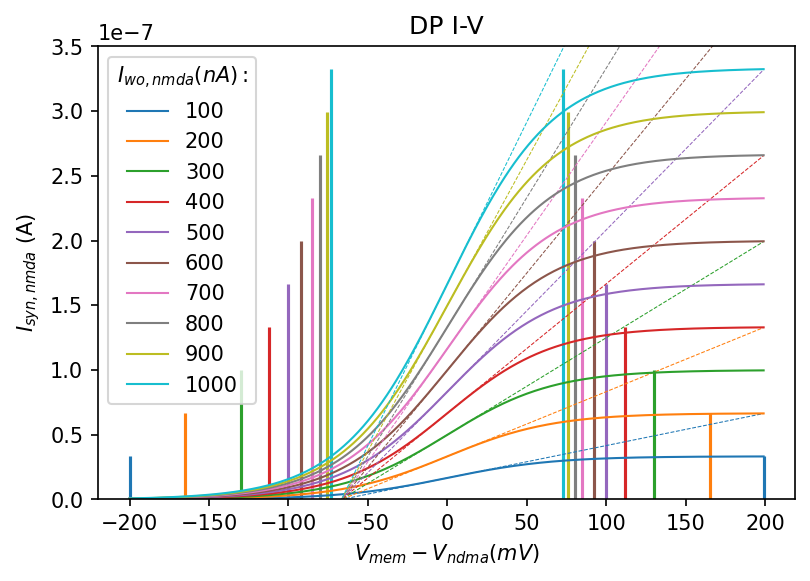

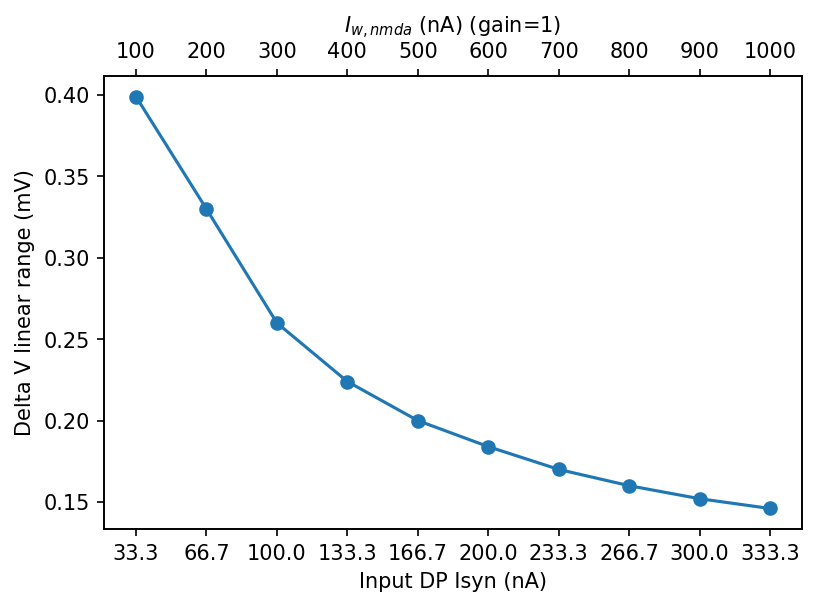

In [10]:
list_vmem_minus_vnmda = np.arange(-200,200)*mV 

range_w_nmda = np.linspace(100,1000,10).astype(int)*nA
f = plt.figure(dpi=150)
#ylim =(-6.648816355951428e-09, 1.396432760447953e-07)
delta_v_linear_sigmoid = []
input_isyn = []
for w, w_nmda in enumerate(range_w_nmda):
    
    dynapse_param['I_wo_syn_nmda'] = w_nmda
    EPSC_nmda = dynapse_param['I_wo_syn_nmda']*dynapse_param['I_g_syn_nmda']/(dynapse_param["I_tau_syn_nmda"]*((dynapse_param["I_g_syn_nmda"]/constants.Io)+1))
    input_isyn.append(EPSC_nmda)
    
    # Sigmoid
    i_syn_nmda = EPSC_nmda/(1 + np.exp(-constants.kappa_n*list_vmem_minus_vnmda/constants.Ut))
    p = plt.plot(list_vmem_minus_vnmda/mV, i_syn_nmda/nA*1e-9, linewidth=1, label=str(int(w_nmda/nA))) 
    
    # Linearization
    slope_sigmoid = constants.kappa_n/constants.Ut*EPSC_nmda/4/nA*1e-9*mV
    offset_sigmoid =EPSC_nmda/2/nA*1e-9
    line = np.polyval([slope_sigmoid, offset_sigmoid], list_vmem_minus_vnmda/mV)
    plt.plot(list_vmem_minus_vnmda/mV, line, c=p[0].get_color(), linestyle='--', linewidth=.5)
    
    # Find sigmoid linear range:
    # Let's define a threshold value to quantify the range of DeltaV=Vmem-Vnmda over which the sigmoid is linear:
    thr = .5*1e-7
    idx_linear = np.where(np.abs(line-i_syn_nmda/nA*1e-9)<=thr)[0]
    delta_v_linear_sigmoid.append(list_vmem_minus_vnmda[idx_linear[-1]]-list_vmem_minus_vnmda[idx_linear[0]])
    
    plt.vlines(list_vmem_minus_vnmda[idx_linear[-1]]/mV, np.min(i_syn_nmda), np.max(i_syn_nmda), color=p[0].get_color())
    plt.vlines(list_vmem_minus_vnmda[idx_linear[0]]/mV, np.min(i_syn_nmda), np.max(i_syn_nmda), color=p[0].get_color())
     
plt.ylim(0,3.5*1e-7)
plt.legend(title='$I_{wo,nmda} (nA):$')
plt.xlabel('$V_{mem}-V_{ndma} (mV)$')
plt.ylabel('$I_{syn,nmda}$ (A)')
plt.title('DP I-V')

plt.figure(dpi=150)
plt.plot(input_isyn/nA, delta_v_linear_sigmoid, '-o')
plt.xlabel('Input DP Isyn (nA)')
plt.ylabel('Delta V linear range (mV)')
ax = plt.gca()
ax.set_xticks(input_isyn/nA)
ax2 = plt.gca().twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels((range_w_nmda/nA).astype(int))
ax2.set_xlabel('$I_{w,nmda}$ (nA) (gain=1)')

* For our coincidence detector to be sensitive to the input ISI, the $I_{syn,nmda}$ should change significantly (e.g from 100% to 0% of the input current if used as a step function), within a time scale (or a delta voltage range) comparable to the time scale of the coincidence detector EPSP in response to an AMPA spike. 
Due to the DP I-V characteristic, the higher the input to the DP $I_{syn}$, the smaller the delta V range needed to 'turn off' the coincidence detector. 
* For example, if **$I_{syn}$=300 nA**, which can be generated with a bias weight current of 900nA (or a lower one if we use a larger gain), the minimum delta V needed to switch from the 'active' to the 'inactive' region of the DP is about 150 mV.

* Therefore, let's set:

In [11]:
dynapse_param['I_wo_syn_nmda'] = 900*nA 

### 2. $I_{w,ampa}$
* If we assume a fixed AMPA time constant (and gain), what is the **AMPA weight bias** current that yields this voltage increase in the membrane voltage of the neuron?

#### Sweep AMPA weight bias (with NMDA synapse off)

#### [ 3. $I_{\tau}$ = $I_{\tau,ampa} \approx 5 ms, I_{\tau,nmda} \gg I_{\tau,ampa}$]

To increase the selectivity of our coincidence detector (and to reduce the complexity of our analysis for now), let's set the **neuron time constant** equal to the ampa tau

In [12]:
dynapse_param['Itau'] = 10 *pA

In [13]:
try:
    network.restore()
except KeyError:
    # Network state has not been stored yet
    network.store()
    
# Input parameters: ===============================================================================================================
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA     
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"]                                               
dynapse_param['I_wo_syn_nmda'] = 0*nA
# =================================================================================================================================
for core in chip.cores:
    set_params(core.neurons, dynapse_param)

# Simulation
duration = 200 * ms
list_w_ampa = np.linspace(1,10,4)
dict_iampa = {}
dict_imem = {}
dict_vmem = {}
for param in list_w_ampa:
    print('w_ampa: ', param)
    dynapse_param['I_wo_syn_ampa'] = param*nA
        
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)
        
    # Simulation
    duration = 200* ms # look at first input spike only

    # Run
    network.run(duration)
    
    dict_iampa[param] = (mon_synapse_ampa.t/ms, mon_synapse_ampa.I_syn_ampa[0])
    dict_imem[param] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    dict_vmem[param] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])   
    network.restore()

w_ampa:  1.0
w_ampa:  4.0
w_ampa:  7.0
w_ampa:  10.0


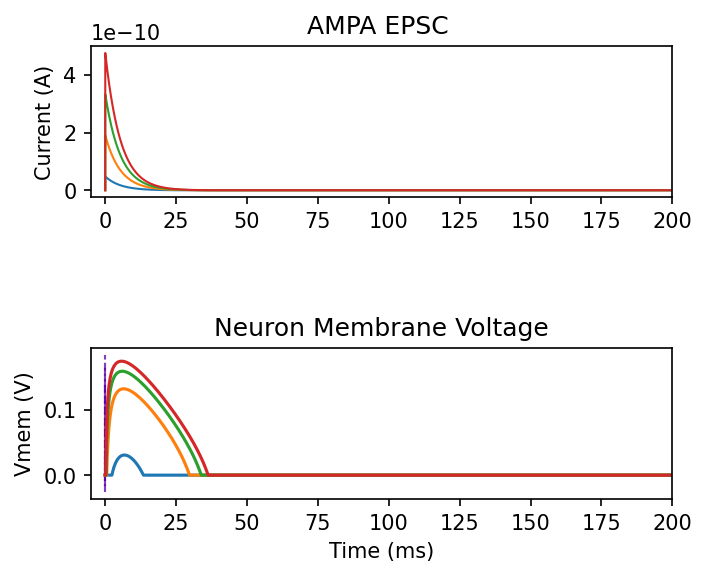

In [15]:
f = plt.figure(figsize=(5,4),dpi=150)
plt.subplots_adjust(hspace=1, wspace=.8)
tstart=0
tend=int(duration*ms)

for key in dict_iampa.keys():
    # Input Spikes 
    plt.subplot(211)
    plt.plot(dict_iampa[key][0], dict_iampa[key][1], linewidth=1)
    plt.xlim(-5, duration/ms)
    plt.ylabel('Current (A)')
    plt.title('AMPA EPSC ')

    plt.subplot(212)
    plt.plot(dict_vmem[key][0], dict_vmem[key][1], linewidth=1.5)
    ylim = plt.ylim()
    plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
    plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
    plt.title('Neuron Membrane Voltage')
    plt.ylabel('Vmem (V)')
    plt.xlim(-5, duration/ms)
    plt.xlabel('Time (ms)')

This result indicates that in orderd to elicit the expected increase in membrane voltage, which triggers the on-off switching behavior of the differential pair, at least an input $I_{w,ampa}$ current would be needed.

In [16]:
dynapse_param['I_wo_syn_ampa'] = 6 * nA 

At this point, what is left to set is the value of the $V_{nmda}$. The NMDA weight was set such that the DP sigmoid characteristic was steep enough (i.e. linear decrease within 100 mV). 

However, due to the large input NMDA current needed to achieve such a steep DP profile, the difference between the Vnmda and the Vmem should be large enough that the output current $I_{syn, nmda}$ is small enough. 

## 4. $V_{nmda}$
Let's chose **$V_{nmda}$ = 400 mV**. This threshold voltage should be large enough, compared to the peak of the AMPA EPSP that, even if the NMDA input is right after the AMPA spike, the fraction of the input synaptic current actually injected into the neuron will not be large enough to elicit an output spike.

### Run (NMDA on)

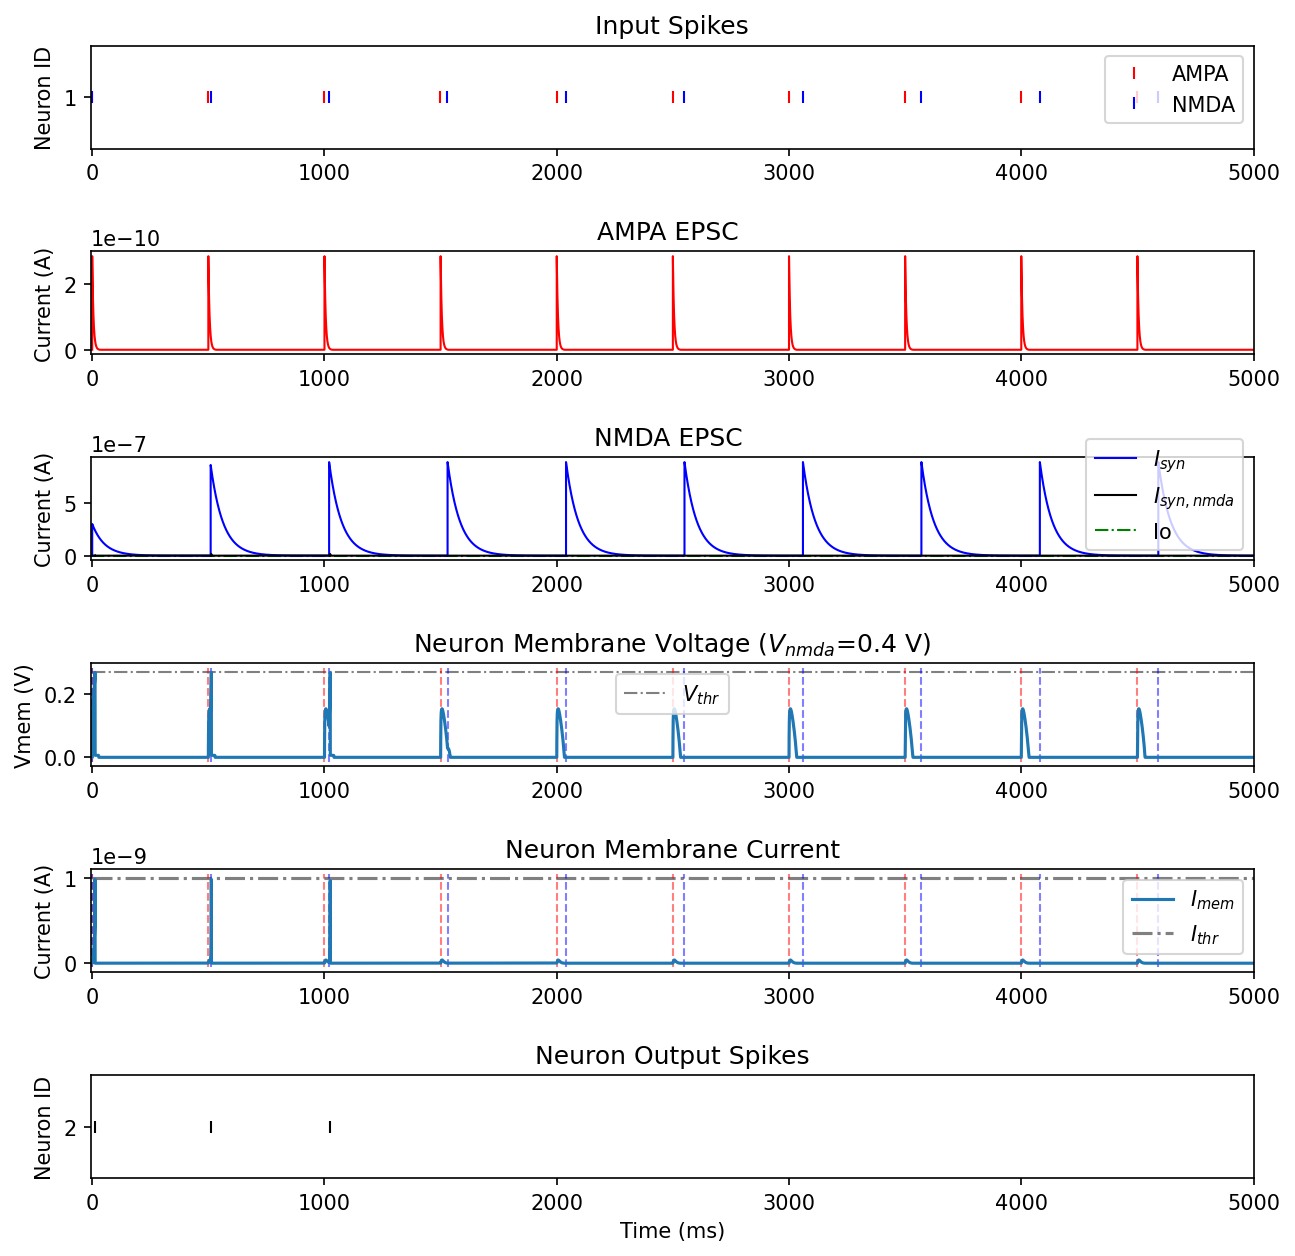

In [17]:
try:
    network.restore()
except KeyError:
    # Network state has not been stored yet
    network.store()
    
# Input parameters: ===============================================================================================================
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA    
dynapse_param['Itau'] = 10 *pA
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"]      
dynapse_param['Vnmda'] = 400*mV
dynapse_param['I_wo_syn_ampa'] = 6 * nA 
dynapse_param['I_wo_syn_nmda'] = 900*nA # chosen based on the DP characteristic                                                                                     
# =================================================================================================================================

for core in chip.cores:
    set_params(core.neurons, dynapse_param)

# Simulation
duration = 5000 * ms

# Run
network.run(duration)

# Plot
f = plt.figure(figsize=(10,10),dpi=150)
plt.subplots_adjust(hspace=1, wspace=.8)
tstart = 0
tend   = int(duration*1000) # ms
Vthr = constants.Ut/DPI_neuron.kappa*log(dynapse_param['Ispkthr']/constants.Io)

# Input Spikes 
plt.subplot(611)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_ampa.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'r|', label='AMPA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_nmda.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'b|', label='NMDA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.legend()
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
plt.xlim(-5, duration/ms)
#plt.xlabel('Time (ms)')

plt.subplot(612)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1, c='r')
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('AMPA EPSC ')

plt.subplot(613)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.I_syn_nmda[0][tstart*s:tend*s], linewidth=1, label='$I_{syn}$', c='b')
plt.plot(mon_neuron_I_syn_nmda.t[tstart*s:tend*s]/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0][tstart*s:tend*s], linewidth=1, c='k', label='$I_{syn,nmda}$')
plt.hlines(y=constants.Io, xmin=-5, xmax=duration/ms, color='green', linestyles='-.', label='Io', linewidth=1)
plt.legend()
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('NMDA EPSC ')

plt.subplot(614)
plt.hlines(y=Vthr, xmin=0, xmax=duration/ms, color='grey', linestyles='-.', linewidth=1, label='$V_{thr}$')
plt.legend()
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_vmem.Vmem[0][tstart*s:tend*s], linewidth=1.5)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.title('Neuron Membrane Voltage ($V_{nmda}$='+str(dynapse_param["Vnmda"])+')')
plt.ylabel('Vmem (V)')
plt.xlim(-5, duration/ms)

plt.subplot(615)
imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, imem)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='grey', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlim(-5, duration/ms)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)


plt.subplot(616)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.xlim(-5, duration/ms)
plt.show()

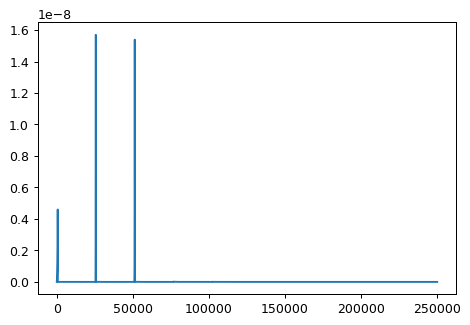

In [21]:
plt.plot(mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0][tstart*s:tend*s])

An output spike is yet elicited at the first 3 input ISI. This is because, even if we set the $V_{nmda}$ such that we settle at the lower tail of the sigmoid function, the nmda current is still large enough to elicit a spike. 

### Now let's sweep over a range of Vnmda values

In [ ]:
output_spikes = {}

network.restore()
dict_vmem = {}
dict_imem = {}
dict_inmda = {}
dict_out_spikes = {}

# Sweep V_nmda threshold values:
sampled_nmda = np.linspace(50, 500, 10).astype(int) #150
    
# Input parameters: ===============================================================================================================
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA         
dynapse_param['Itau'] = 10 *pA
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"] 
dynapse_param['I_wo_syn_nmda'] = 900*nA # chosen based on the DP characteristic                                                                                     
dynapse_param['I_wo_syn_ampa'] = 6 * nA # chosen based on the delta v
# =================================================================================================================================

for vnmda in sampled_nmda:
    print('Vnmda: ', vnmda)
    dynapse_param['Vnmda'] = vnmda*mV
        
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)
        
    # Simulation
    duration = inp_duration * 1000 * ms

    # Run
    network.run(duration)
    
    dict_inmda[vnmda] = (mon_neuron_I_syn_nmda.t/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0])
    dict_imem[vnmda] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    dict_vmem[vnmda] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])
    dict_out_spikes[vnmda] = mon_neuron_output.t/ms
    # (The next one does not depend on Vnmda)
    iampa = (mon_synapse_ampa.t/ms, mon_synapse_ampa.I_syn_ampa[0])
    
    network.restore()
    
# Plot output spikes:
f = plt.figure(figsize=(8,2),dpi=150)
plt.subplot(111)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
plt.title('Output Spikes')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.8, 1.18))

# For each pair of input ISI, label the pair of input spike with True if an output spike was generated. 
mask_out_spike = {}
for nmda in sampled_nmda:
    
    mask_out_spike[nmda] = np.zeros(len(spike_timing_ampa))
    # Loop over the spike times of the AMPA synapse
    for ii, t_ampa in enumerate(spike_timing_ampa/ms):
        # If any output spike is recorded during that time window:
        if len(np.where( np.logical_and( dict_out_spikes[nmda]>=t_ampa, dict_out_spikes[nmda]<(t_ampa+1/rate*1e3) ) )[0])>0:
            mask_out_spike[nmda][ii]=1
            
# This mask will be used in the following section

Vnmda:  50
Vnmda:  100
Vnmda:  150
Vnmda:  200
Vnmda:  250
Vnmda:  300
Vnmda:  350
Vnmda:  400
Vnmda:  450
Vnmda:  500


### Plot

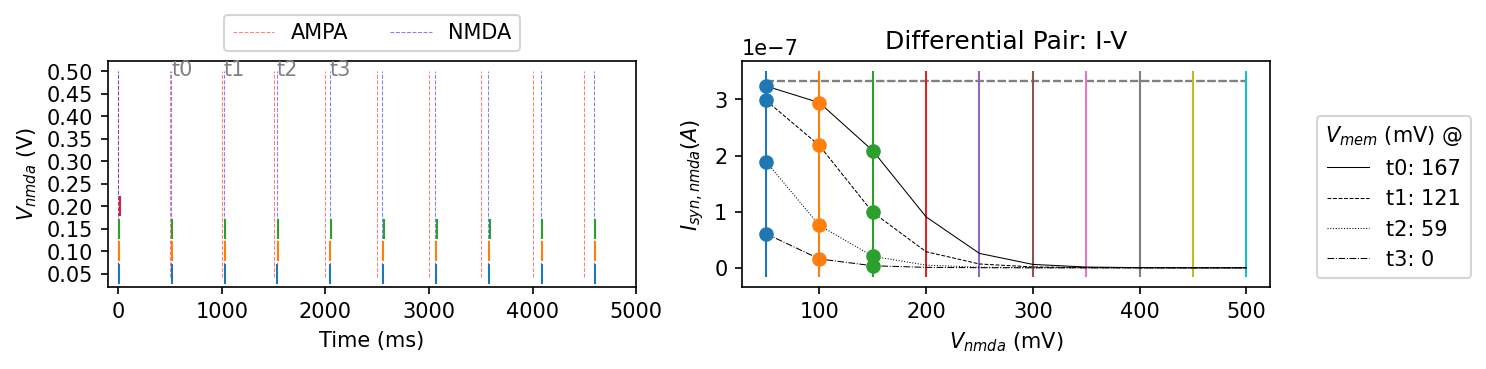

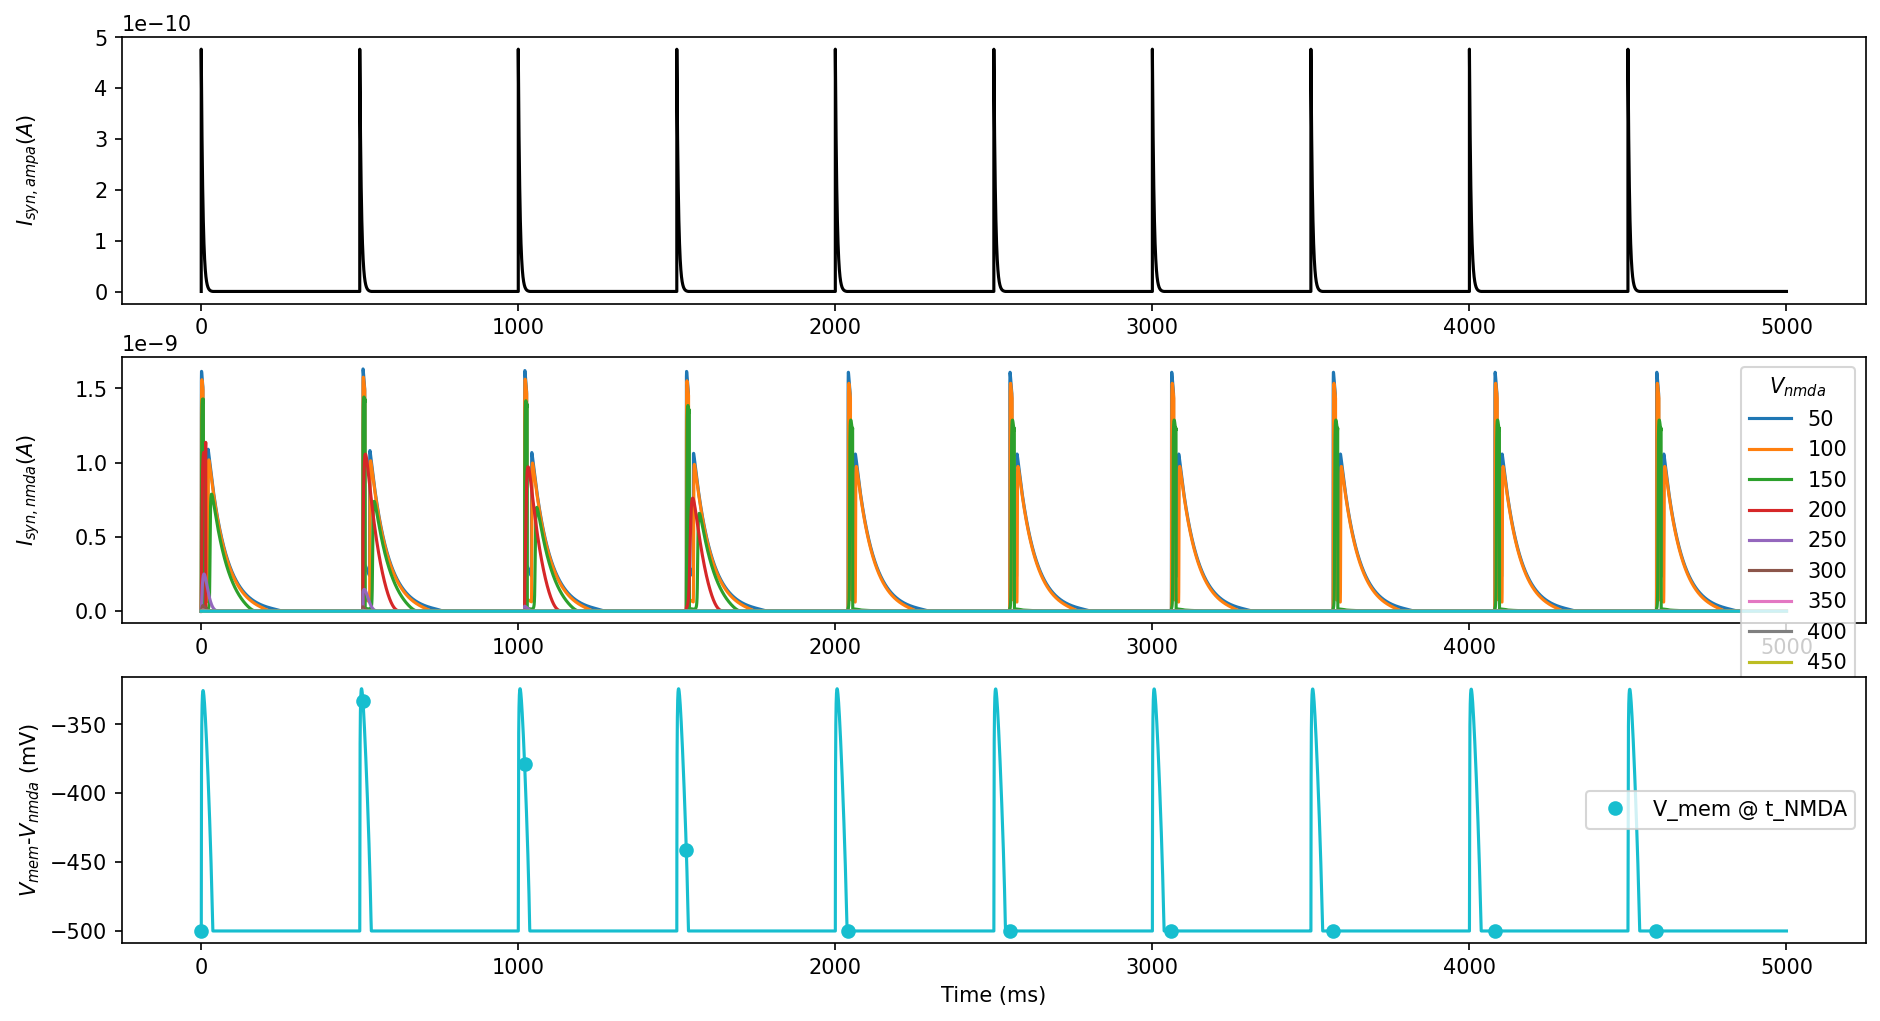

In [54]:
# Plot output spikes:
f = plt.figure(figsize=(10,2),dpi=150)

# Rasterplot
plt.subplot(121)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(.5, 1.25))

input_isi = spike_timing_nmda[1:5]-spike_timing_ampa[1:5]
for ii, isi in enumerate(input_isi):
    plt.text(spike_timing_nmda[1+ii]/ms, ylim[-1]-.01, 't'+str(ii), c='grey')
    
# DPI Characteristics
I_syn = EPSC_nmda
plt.subplot(122)
style = ['solid', 'dashed', 'dotted', 'dashdot']

# Range Vmem
t_vmem = dict_vmem[list(dict_vmem.keys())[0]][0]
vmem = dict_vmem[list(dict_vmem.keys())[0]][1]
idx_vmem_at_nmda = [np.where(t_vmem<=t_nmda)[0][-1] for t_nmda in spike_timing_nmda/ms]
vmem_at_nmda = vmem[idx_vmem_at_nmda]/mV

# I-Vnmda curves for a range of vmem values
for v, vmem in enumerate(vmem_at_nmda[1:5]):
    vmem = vmem*mV
    i_syn_nmda = I_syn/(1 + np.exp(constants.kappa_n*(sampled_nmda*mV-vmem)/constants.Ut))
    p = plt.plot(sampled_nmda, i_syn_nmda/nA*1e-9, linestyle=style[v],c='k', linewidth=.5, label='t'+str(v)+': '+str(int(vmem/mV)))
    plt.hlines(y=I_syn/nA*1e-9, xmin=sampled_nmda[0], xmax=sampled_nmda[-1], linestyle='--', color='grey', linewidth=1)

ylim = plt.ylim()
for i, vnmda in enumerate(sampled_nmda):
    plt.vlines(vnmda, ylim[0], ylim[1], linestyle='-', color=colors[i], linewidth=1)

plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.4, 0.4), title='$V_{mem}$ (mV) @')
plt.xlabel('$V_{nmda}$ (mV)')
plt.ylabel('$I_{syn,nmda} (A)$')
plt.title('Differential Pair: I-V')

# Label intersection between DP characteristic and Vnmda if an output spike was generated:
for vv, vmem in enumerate(vmem_at_nmda[1:5]):
    for nn, vnmda in enumerate(sampled_nmda):
        if mask_out_spike[vnmda][vv+1]==1: # +1 because we are skipping the first input pair of spikes
            i_syn_nmda = I_syn/(1 + np.exp(constants.kappa_n*(vnmda-vmem)*mV/constants.Ut))
            plt.plot(vnmda, i_syn_nmda, 'o', c=colors[nn])
            
# Plot Vmem, EPSC AMPA, and EPSC NMDA as a function of Vnmda
f = plt.figure(figsize=(15,8),dpi=150)
plt.subplot(3,1,1)
plt.plot(iampa[0], iampa[1], c='k')
plt.ylabel('$I_{syn,ampa} (A) $')
plt.subplot(3,1,2)
for vnmda in sampled_nmda:
    plt.plot(dict_inmda[vnmda][0], dict_inmda[vnmda][1], label=str(vnmda))
plt.legend(title='$V_{nmda}$')

plt.ylabel('$I_{syn,nmda} (A) $')
plt.subplot(3,1,3)
plt.plot(dict_vmem[sampled_nmda[-1]][0], dict_vmem[sampled_nmda[-1]][1]/mV-sampled_nmda[-1], c=colors[len(sampled_nmda)-1])
plt.plot(spike_timing_nmda/ms,vmem_at_nmda-sampled_nmda[-1], 'o', c=colors[len(sampled_nmda)-1], label='V_mem @ t_NMDA')
plt.legend()
plt.ylabel('$V_{mem}$-$V_{nmda}$ (mV)')
plt.xlabel('Time (ms)')

f.align_ylabels()